In [1]:
# load libraries
#%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle

# List of FIPS state ids
states = ['01', '03', '04', '05', '06', '08', '09', '10', '11', '12', '13', '14', '16', '17', '18', '19', '20', 
         '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', 
         '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53',
          '54', '55', '56']

#       ,'02', '15'] 

# Dictionary connecting state names and FIPS ids
states_dict = {'Alabama':'01', 'Arizona':'03', 'Arkansas':'05', 'California':'06', 'Colorado':'08', 
              'Connecticut':'09', 'Delaware':'10', 'District of Columbia':'11', 'Florida':'12',
              'Georgia':'13', 'Idaho':'16', 'Illinois':'17', 'Indiana':'18', 'Iowa':'19', 'Kansas':'20',
              'Kentucky':'21', 'Louisiana':'22', 'Maine':'23', 'Maryland':'24', 'Massachusetts':'25',
              'Michigan':'26', 'Minnesota':'27', 'Mississippi':'28', 'Missouri':'29', 'Montana':'30',
              'Nebraska':'31', 'Nevada':'32', 'New Hampshire':'33', 'New Jersey':'34', 'New Mexico':'35',
              'New York':'36', 'North Carolina':'37', 'North Dakota':'38', 'Ohio':'39', 'Oklahoma':'40',
              'Oregon':'41', 'Pennsylvania':'42', 'Rhode Island':'44', 'South Carolina':'45', 
              'South Dakota':'46', 'Tennessee':'47', 'Texas':'48', 'Utah':'49', 'Vermont':'50',
              'Virginia':'51', 'Washington':'53', 'West Virginia':'54', 'Wisconsin':'55', 'Wyoming':'56'}

#              'Alaska':'02', 'Hawaii':'15'}

In [2]:
# Provide location of data files
geo_fp = '../data_geographic/geojson-counties-fips.json'
pop_fp = '../data_population/co-est2019-alldata.csv'
#covid_fp =  '../NYT-covid-19-data/us-counties.csv'


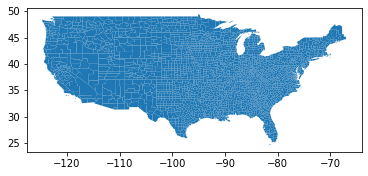

In [3]:
# Read geographic json data into geopandas dataframe 'gdf'
gdf = gpd.read_file(geo_fp)

# I filtered out Alaska and Hawaii initially to make the map plot more clear 
gdf = gdf[gdf['STATE'].isin(states)]

# The data is not in an easily readable order, so I sort gdf by the 'id' column, which is the county FIPS number
# 'inplace=True' means the existing data frame is replaced with the sorted data frame this is the same as 
# 'gdf = gdf.sort_values(by='id')'
gdf.sort_values(by='id', inplace=True)

# Resets the numbering of the row indices
gdf.reset_index(inplace=True)

# There were originally 9 columns in gdf, I only need 5 for the data analysis we are doing so I only keep those
# five. Also, this command specifies the order of the retained data in the data frame, which can be useful.
gdf = gdf[['id','STATE','COUNTY','NAME','geometry']]

# I don't like the existing column titles and the variation in capitalization. So I change the titles to be more
# explicit and I make everything lower case for consistency.
gdf = gdf.rename(index=str, 
                       columns={'id':'fips', 'STATE':'state_code', 'COUNTY':'county_code', 'NAME':'county_name'})

# At this point we do some kludging of the data. FIPS number 51515, which was the town of Bedford, VA
# no longer exists. And has been assimilated by Bedford county, with FIPS 51019. So to be consistent with the 
# census data, we have to drop that row from gdf. There are a couple ways to do this. We can just brute force
# it to find that row index is 2882 and issue a drop command. 
#    gdf.loc[gdf['fips']=='51515']
#    gdf.loc[gdf['fips']=='51019']
#    gdf= gdf.drop('2882', axis=0)

# Or we can use th gdf.index command as follows
idx = gdf.index[gdf['fips']=='51515']
gdf = gdf.drop(idx, axis=0)

# Again, we renumber the row indices (otherwise there is an empty row at 2882).
gdf.reset_index(inplace=True, drop=True)

# And then for giggles, we can plot gdf
gdf.plot()

# You can check that the town of Bedford is not longer in gdf
#gdf.loc[gdf['fips']=='51515']

In [4]:
#gdf.loc[gdf['fips']=='46113']
gdf

,fips,state_code,county_code,county_name,geometry
0,01001,01,001,Autauga,"POLYGON ((-86.49677 32.34444, -86.71790 32.402..."
1,01003,01,003,Baldwin,"POLYGON ((-87.59893 30.99745, -87.59411 30.976..."
2,01005,01,005,Barbour,"POLYGON ((-85.05603 32.06305, -85.05021 32.024..."
3,01007,01,007,Bibb,"POLYGON ((-87.42120 32.87451, -87.42013 32.902..."
4,01009,01,009,Blount,"POLYGON ((-86.57780 33.76532, -86.75914 33.840..."
...,...,...,...,...,...
3103,56037,56,037,Sweetwater,"POLYGON ((-110.04800 41.57802, -110.05371 42.2..."
3104,56039,56,039,Teton,"POLYGON ((-111.04875 44.06040, -111.04875 44.0..."
3105,56041,56,041,Uinta,"POLYGON ((-111.04640 41.57984, -110.06279 41.5..."
3106,56043,56,043,Washakie,"POLYGON ((-108.55076 44.07940, -108.55056 44.1..."


In [5]:
# OK, now we go through similar manipulations for the data from the US Census Bureau
#
# First, read the data in from the csv file. Note that you have to specify the text encoding specifically 
# or it will default to UTF-8, and will crap out. Also we need to ensure that the STATE and COUNTY data is
# read as strings, not integers.
df=pd.read_csv(pop_fp, encoding='ISO-8859-1', dtype={'STATE':'str', 'COUNTY':'str'} )

# Again we perform a bunch of filtering on the dataframe because there is a ton of rows and columns that we
# do not need for this work. 
# SUMLEV is a column title. SUMLEV = 40 means that row has state data. SUMLEV = 50 means county data. We don't
# need state data so we cut it out.
df=df[df.SUMLEV != 40]

# We only want five columns: state id, county id, state name, county name and 2019 population. Feel free to 
# look at all the other data which is contained in the dataframe. We also only want the lower 48 states, so 
# filter out Alaska and Hawaii. 
df=df[['STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'POPESTIMATE2019']]
df = df[df['STATE'].isin(states)]

# Change the names of the columns.
df = df.rename(index=str, 
                       columns={'STATE':'state_code', 'COUNTY':'county_code',
                                'STNAME':'state_name', 'CTYNAME':'county_name',
                                'CTYNAME':'county_name', 'POPESTIMATE2019':'population' })

# Make a new column for the FIPS number and reorder the columns
df['fips']=df['state_code']+df['county_code']
df=df[['fips', 'state_code', 'state_name', 'county_code', 'county_name','population']]

# The row indices are not continuous becase we dropped out Alaska and Hawaii, so reset them.
df.reset_index(inplace=True, drop=True)

# Finally, FIPS 46102 has been replaced by 46113 
df.at[2378,'fips'] = '46113'
df

,fips,state_code,state_name,county_code,county_name,population
0,01001,01,Alabama,001,Autauga County,55869
1,01003,01,Alabama,003,Baldwin County,223234
2,01005,01,Alabama,005,Barbour County,24686
3,01007,01,Alabama,007,Bibb County,22394
4,01009,01,Alabama,009,Blount County,57826
...,...,...,...,...,...,...
3103,56037,56,Wyoming,037,Sweetwater County,42343
3104,56039,56,Wyoming,039,Teton County,23464
3105,56041,56,Wyoming,041,Uinta County,20226
3106,56043,56,Wyoming,043,Washakie County,7805


In [6]:
# So now we have gdf and df and need to merge them so we have the population and geo data for each county FIPS
# We don't need duplicate columns for things like county name, we only merge fips and population from df.

gdf = gdf.merge(df[['fips','population']], on='fips')

In [7]:
gdf

,fips,state_code,county_code,county_name,geometry,population
0,01001,01,001,Autauga,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",55869
1,01003,01,003,Baldwin,"POLYGON ((-87.59893 30.99745, -87.59411 30.976...",223234
2,01005,01,005,Barbour,"POLYGON ((-85.05603 32.06305, -85.05021 32.024...",24686
3,01007,01,007,Bibb,"POLYGON ((-87.42120 32.87451, -87.42013 32.902...",22394
4,01009,01,009,Blount,"POLYGON ((-86.57780 33.76532, -86.75914 33.840...",57826
...,...,...,...,...,...,...
3103,56037,56,037,Sweetwater,"POLYGON ((-110.04800 41.57802, -110.05371 42.2...",42343
3104,56039,56,039,Teton,"POLYGON ((-111.04875 44.06040, -111.04875 44.0...",23464
3105,56041,56,041,Uinta,"POLYGON ((-111.04640 41.57984, -110.06279 41.5...",20226
3106,56043,56,043,Washakie,"POLYGON ((-108.55076 44.07940, -108.55056 44.1...",7805


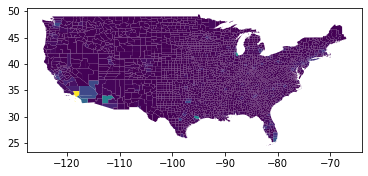

In [8]:
gdf.plot(column='population')

In [11]:
# Dump gdf to pickle file
with open('us_county_geo_pop_gdf.pickle', 'wb') as f:
    pickle.dump(gdf, f, pickle.HIGHEST_PROTOCOL)


In [12]:
# Read gdf from pickle file
with open('us_county_geo_pop_gdf.pickle', 'rb') as f:
    pickle_gdf = pickle.load(f)
    
pickle_gdf

,fips,state_code,county_code,county_name,geometry,population
0,01001,01,001,Autauga,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",55869
1,01003,01,003,Baldwin,"POLYGON ((-87.59893 30.99745, -87.59411 30.976...",223234
2,01005,01,005,Barbour,"POLYGON ((-85.05603 32.06305, -85.05021 32.024...",24686
3,01007,01,007,Bibb,"POLYGON ((-87.42120 32.87451, -87.42013 32.902...",22394
4,01009,01,009,Blount,"POLYGON ((-86.57780 33.76532, -86.75914 33.840...",57826
...,...,...,...,...,...,...
3103,56037,56,037,Sweetwater,"POLYGON ((-110.04800 41.57802, -110.05371 42.2...",42343
3104,56039,56,039,Teton,"POLYGON ((-111.04875 44.06040, -111.04875 44.0...",23464
3105,56041,56,041,Uinta,"POLYGON ((-111.04640 41.57984, -110.06279 41.5...",20226
3106,56043,56,043,Washakie,"POLYGON ((-108.55076 44.07940, -108.55056 44.1...",7805
